# 深度学习建模流程 

数据准备就绪，接下来就是建模实验环节，在实际深度学习建模过程中，无论是手动实现还是调库实现，我们都需要遵循深度学习建模一般流程。在此前的学习过程中，我们曾两次提及深度学习建模流程，结合此前学习内容，我们先进行简单回顾

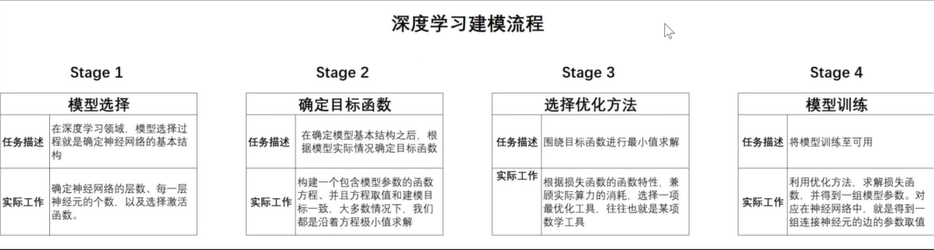

# 线性回归的手动实现 

<li>首先考虑如何手动实现建模过程

In [12]:
# 随机模块
import random

# 绘图模块
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

## 生成数据集 

利用此前的数据集生成函数，创建一个真实关系为y = 2x1 - x2 + 1，且扰动项不是很大的回归类数据集。

In [13]:
torch.manual_seed(420)
features,labels = tensorGenReg()

## 建模流程 

### 模型选择 

围绕建模目标，我们可以构建一个只包含一层的神经网络进行建模

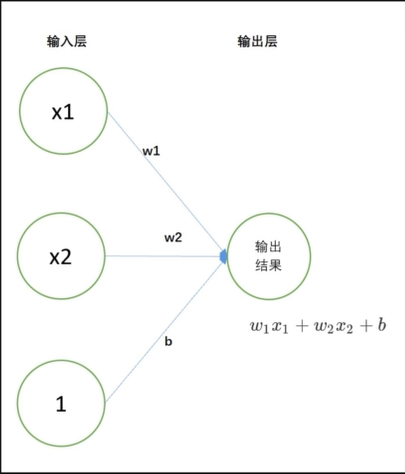

In [14]:
def linreg(X,w):
    return torch.mm(X,w)

### 确定目标函数 

和此前一样，我们使用MSE作为损失函数，也就是目标函数

In [15]:
def squared_loss(y_hat,y):
    num_ = y.numel()
    sse = torch.sum((y_hat.reshape(-1,1) - y.reshape(-1,1))**2)
    return sse/num_

### 定义优化算法 

此处我们采用小批量梯度下降进行求解，每一次迭代过程都是(参数-学率*梯度)

In [16]:
def sgd(params,lr):
    params.data -= lr * params.grad
    params.grad.zero_()

    注：关于可微张量的in-place operation (对原对像修改操作)的相关讨论

(1).正常情况下，可微张量的in-place operation会导致系统无法区分叶节点和其他节点的问题

In [17]:
w = torch.tensor(2.,requires_grad = True)
w

tensor(2., requires_grad=True)

In [18]:
w.is_leaf

True

开启可微之后，w的所有计算都会被纳入计算图中

In [19]:
w1 = w*2
w1

tensor(4., grad_fn=<MulBackward0>)

但如果在计算过程中，我们使用in-place operation，让新生成的值替换w原始值，则会报错

In [20]:
w = torch.tensor(2.,requires_grad = True)
# w -= w * 2

从报错信息中可知，PVlorch中不允许叶节点使用in-place operation，根本原因是会造成叶节点和其他节点类型混乱。不过，虽然可微张量不允许in.place operation，但却可以通过其他方法进行对w进行修改。

In [21]:
w = torch.tensor(2.,requires_grad = True)
w = w * 2
w

tensor(4., grad_fn=<MulBackward0>)

不过此时，w就不再是叶节点了,自然，我们也无法通过反向传播求其导数

In [22]:
w.is_leaf

False

In [23]:
w.backward() # w已经成为输出节点

In [24]:
w.grad

C:\Users\Kun\AppData\Local\Temp\ipykernel_28880\447174752.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:491.)
  w.grad


而在一张计算图中失的相关操作。缺少了对叶节点反向传播求导数的相关运算，计算图也就失去了核心价值。因此在实际操作过程中，应该尽量避免导致叶节点丢

(2).叶节点数值修改方法

当然，如果出现了一定要修改叶节点的取值的情况典型的如梯度下降过程中利用梯度值修改参数值时，可以使用此前介绍的暂停追踪的方法使得修改叶节点数值时暂停追踪，然后再生成新的叶节点带入计算，如:如使用with torch.no grad0语句或者torch.detach0方法，

<li>利用with torch.no grad()暂停追踪

In [25]:
w = torch.tensor(2.,requires_grad = True)
w

tensor(2., requires_grad=True)

In [26]:
with torch.no_grad():
    w -= w*2
w

tensor(-2., requires_grad=True)

In [27]:
w.is_leaf

True

<li>利用detach生成新变量

In [28]:
w = torch.tensor(2.,requires_grad = True)
w

tensor(2., requires_grad=True)

In [29]:
w.detach_()

tensor(2.)

In [30]:
w -= w * 2
w

tensor(-2.)

In [31]:
w.requires_grad = True
w

tensor(-2., requires_grad=True)

In [32]:
w.is_leaf

True

<li>使用.data来返回可微张量的取值，从在避免在修改的过程中被追踪

In [33]:
w = torch.tensor(2.,requires_grad = True)
w

tensor(2., requires_grad=True)

In [34]:
w.data           # 查看张量的数值

tensor(2.)

In [35]:
w                # 但不改变张量本身的可微性

tensor(2., requires_grad=True)

In [36]:
w.data -= w * 2 # 对其数值进行修改

In [37]:
w

tensor(-2., requires_grad=True)

In [38]:
w.is_leaf        # 张量仍然是叶节点

True

###  训练模型

In [39]:
# 设置随机数种子
torch.manual_seed(420)

# 初始化核心参数
batch_size = 10 # 每一个小批的数量
lr = 0.03       # 学习率
num_epochs = 3  # 训练过程遍历几次数据
w = torch.zeros(3,1,requires_grad = True) # 随机设置初始权重

# 参与训练的模型方程
net = linreg        # 使用回归方程
loss = squared_loss # MSE作为损失函数

# 模型训练过程
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w),y)
        l.backward()
        sgd(w,lr)
    train_l = loss(net(features,w),labels)
    print('epoch %d, loss %f'%(epoch+1,train_l))

epoch 1, loss 0.000131
epoch 2, loss 0.000101
epoch 3, loss 0.000102


In [40]:
w

tensor([[ 1.9994],
        [-1.0001],
        [ 1.0002]], requires_grad=True)

当然，我们也可以使用tensorboard记录上述迭代过程中loss的变化过程

In [41]:
writer = SummaryWriter(log_dir='reg_loss')

In [42]:
# 设置随机数种子
torch.manual_seed(420)

# 初始化核心参数
batch_size = 10 # 每一个小批的数量
lr = 0.03       # 学习率
num_epochs = 3  # 训练过程遍历几次数据
w = torch.zeros(3,1,requires_grad = True) # 随机设置初始权重

# 参与训练的模型方程
net = linreg        # 使用回归方程
loss = squared_loss # MSE作为损失函数

# 模型训练过程
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w),y)
        l.backward()
        sgd(w,lr)
    train_l = loss(net(features,w),labels)
    writer.add_scalar('mul',train_l,epoch)

    命令行输入：
    conda ...
    E:
    cd ...
    tensorboard --logdir="reg_loss"

打开浏览器，输入 localhost:6006，查看绘制图像

# 线性回归的快速实现 

当然，我们可以按照此前课程介绍的，通过调用PyTorch中的函数和类，程完成的模型构建，相关变量的符号也沿用了Lesson 11中的书写标准直接完成建模。当然，该过程也是严格按照此前介绍的深度学习建模流

## 定义核心参数

In [43]:
batch_size = 10  # 每一个小批的数量
lr = 0.03           # 学习率
num_epochs = 3      # 训练过程遍历几次数据

## 数据准备

In [44]:
torch.manual_seed(420)     # 设置随机数种子

# 创建数据集
features, labels = tensorGenReg()
features = features[:,:-1] # 剔除最后全是1的列
data = TensorDataset(features,labels)
batchData = DataLoader(data,batch_size=batch_size,shuffle=True)

In [45]:
features

tensor([[-0.0070,  0.5044],
        [ 0.6704, -0.3829],
        [ 0.0302,  0.3826],
        ...,
        [-0.9164, -0.6087],
        [ 0.7815,  1.2865],
        [ 1.4819,  1.1390]])

## 定义模型 

In [48]:
class LR(nn.Module):
    # 定义模型的点线结构
    def __init__(self,in_features = 2,out_features = 1):
        super().__init__()
        self.linear = nn.Linear(in_features,out_features)
    # 定义模型的正向传播规则
    def forward(self,x):
        out = self.linear(x)
        return out

# 实例化模型
LR_model = LR()

## 定义损失函数 

In [49]:
criterion = nn.MSELoss()

## 定义优化方法 

In [51]:
optimizer = optim.SGD(LR_model.parameters(),lr=0.03)

## 模型训练 

In [53]:
def fit(net,criterion,optimizer,batchdata,epochs):
    for epoch in range(epochs):
        for X,y in batchdata:
            yhat = net.forward(X)
            loss = criterion(yhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        writer.add_scalar('loss',loss,global_step=epoch)

当然，由于上述模型只有一层，因此也可以通过nn.Linear(2,1)函数直接建模

接下来，即可执行模型训练

In [54]:
# 设置随机数种子
torch.manual_seed(420)

fit(net = LR_model
   ,criterion = criterion
   ,optimizer = optimizer
   ,batchdata = batchData
   ,epochs = num_epochs)

查看模型训练结果

In [55]:
LR_model

LR(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [56]:
# 查看模型参数
list(LR_model.parameters())

[Parameter containing:
 tensor([[ 2.0006, -1.0000]], requires_grad=True),
 Parameter containing:
 tensor([1.0008], requires_grad=True)]

In [57]:
# 计算MSE
criterion(LR_model(features),labels)

tensor(0.0001, grad_fn=<MseLossBackward0>)

由于数据本身就是按照y= 2x1 - 2+1基本规律加上扰动项构建的，因此通过训练完成的参数可以看出模型效果较好。当然，真实场景下我们无法从上帝视角获得真实的数据分布规律，然后通过比对模型来判断模型好坏，此时我们就需要明确模型评估指标，相关内容我们将在下一节课详细介绍。

当然，我们也可以通过add_graph方法，在writer中添加上述模型的记录图

In [58]:
writer.add_graph(LR_model,(features,))

# 简单线性回归的局限性 

此处我们进一步进行简单实验，当自变量和因变量满足最高次方为2次方的多项式函数关系时,<br>或者扰动项增加时简单线性回归误差将迅速增大